# Master's thesis case study 1

In [4]:
%load_ext autoreload
%autoreload 2

In [27]:
import numpy
import torch
from adaptive_nof1 import *
from adaptive_nof1.policies import *
from adaptive_nof1.helpers import *
from adaptive_nof1.inference import *
from adaptive_nof1.metrics import *
from matplotlib import pyplot as plt

In [3]:
# Setup generic n-of-1 parameters

length = 6
number_of_actions = 3
number_of_patients = number_of_actions ** (length - number_of_actions) * 100

In [4]:
# In this case study, we assume a know variance of 1 and three independent variables.
# Our data generating model can therefore be expressed as a multivariate normal with \eye as the covariance matrics
class MultivariateNormal(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.mu = [0.0, 1.0, 1.0]
        self.patient_id = patient_id
        self.distribution = torch.distributions.MultivariateNormal(torch.tensor(self.mu), torch.eye(len(self.mu)))

    @property
    def additional_config(self):
        return {"expectations_of_interventions": self.mu}
 
    
    def generate_context(self, history):
        return {}

    def observe_outcome(self, intervention, context):
        return {"outcome": self.distribution.sample()[intervention["treatment"]].item()}

    def __str__(self):
        return f"MultivariateNormal {self.mu}"

data_generating_model = lambda patient_id: MultivariateNormal(patient_id)

In [5]:
from adaptive_nof1 import SeriesOfSimulationsRunner
from adaptive_nof1.policies import FixedIndexedPolicy, FrequentistEpsilonGreedy, ConstantPolicy
from adaptive_nof1.inference import NormalKnownVariance

fixed_schedule_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FixedIndexedPolicy(number_of_actions=number_of_actions,
                              inference=NormalKnownVariance(
                                  variance=1,
    )
    ),
)

fixed_schedule_data = fixed_schedule_runner.simulate(length)

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
from adaptive_nof1.metrics import *
from adaptive_nof1.series_of_simulations_data import SeriesOfSimulationsData

def debug_data_to_torch_distribution(debug_data):
    mean = debug_data["mean"]
    variance = debug_data["variance"]
    cov = torch.diag_embed(torch.tensor(variance))
    return torch.distributions.MultivariateNormal(torch.tensor(mean), cov)

SeriesOfSimulationsData.plot_lines(
    [fixed_schedule_data],
    [
        SimpleRegretWithMean(),
        CumulativeRegret(),
        KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)

NameError: name 'fixed_schedule_data' is not defined

In [ ]:
fixed_schedule_data.plot_allocations()

In [ ]:
from adaptive_nof1.helpers import index_to_value_counts

df = SeriesOfSimulationsData.score_data(
    [fixed_schedule_data],
    [SimpleRegretWithMean(), CumulativeRegret(), KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)],
)

df = df.loc[df["t"] == df["t"].max()]
df["id"] = df["patient_id"].astype(int).mod(number_of_actions ** (length - number_of_actions))
df["allocations"] = df["patient_id"].apply(lambda x: index_to_values([3,3,3], int(x)))
df.set_index(["patient_id", "metric"]).groupby(["id", "metric"])["score"].mean().unstack()
groupby = df.set_index(["patient_id", "metric"]).groupby(["id", "metric"])["score"].mean().unstack()
groupby["allocations"] = groupby.index.to_frame()["id"].apply(lambda x: index_to_value_counts([3,3,3], int(x)))
groupby = pd.concat([groupby, pd.DataFrame(groupby['allocations'].tolist())], axis=1)
groupby

## These are no value counts these are just copies :/

In [ ]:
# Interesting obervation: We do not need all of these indices, since we can reduce our problem to the number each element was picked.

## Simulation Study 1: Thompson vs UCB

In [9]:
# Initial parameters
block_length = 5
length = 6 * block_length
number_of_actions = 2
number_of_patients = 100

In [16]:
# Scenarios
class NormalModel(Model):
    def __init__(self, patient_id, mean, variance):
        self.rng = numpy.random.default_rng(patient_id)
        self.mean = mean
        self.variance = variance
        self.patient_id = patient_id

    def generate_context(self, history):
        return {}

    @property
    def additional_config(self):
        return {"expectations_of_interventions": self.mean}

    def observe_outcome(self, action, context):
        treatment_index = action["treatment"]
        return {"outcome": self.rng.normal(self.mean[treatment_index], self.variance[treatment_index])}

    def __str__(self):
        return f"NormalModel({self.mean, self.variance})"

generating_scenario_I = lambda patient_id: NormalModel(patient_id, mean=[0, 0], variance=[1,1])
generating_scenario_II = lambda patient_id: NormalModel(patient_id, mean=[1, 0], variance=[1,1])
generating_scenario_III = lambda patient_id: NormalModel(patient_id, mean=[2, 0], variance=[1,1])
generating_scenario_IV = lambda patient_id: NormalModel(patient_id, mean=[1, 0, 0], variance=[1,1,1])
generating_scenario_V = lambda patient_id: NormalModel(patient_id, mean=[2, 1, 0], variance=[1,1,1])

In [17]:
# Inference Model
inference_model = lambda: NormalKnownVariance(prior_mean=0, prior_variance=1, variance=1)

In [18]:
# Policies

fixed_policy = BlockPolicy(
    block_length = block_length,
    internal_policy = FixedPolicy(
        number_of_actions=2,
        inference_model = inference_model(),
    )
)  

thompson_sampling_policy = BlockPolicy(
    block_length = block_length,
    internal_policy = ThompsonSampling(
        inference_model=inference_model(),
        number_of_actions=2,
    )
)

ucb_policy = BlockPolicy(
    block_length = block_length,
    internal_policy = UpperConfidenceBound(
        inference_model=inference_model(),
        number_of_actions=2,
        epsilon=0.05,
    )
)

In [76]:
# Full crossover study
study_designs = {
    "n_patients": [number_of_patients],
    "policy": [fixed_policy, thompson_sampling_policy, ucb_policy],
    # "policy": [two_means_ts, linear_regression_ts, constant_ts],
    "model_from_patient_id": [
        generating_scenario_I, generating_scenario_II, generating_scenario_III, generating_scenario_IV, generating_scenario_V,
    ],
}
configurations = generate_configuration_cross_product(study_designs)

In [77]:
calculated_series, config_to_simulation_data = simulate_configurations(
    configurations, length
)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [80]:
# Metric1, Metric2, Metric3
# Env 1
# Env 2
# Env 3
metrics = [
    SimpleRegretWithMean(),
    CumulativeRegret(),
    #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
]
model_mapping = {
    "NormalModel(([0, 0], [1, 1]))": "Scenario I",
    "NormalModel(([1, 0], [1, 1]))": "Scenario II",
    "NormalModel(([2, 0], [1, 1]))": "Scenario III",
    "NormalModel(([1, 0, 0], [1, 1, 1]))": "Scenario IV",
    "NormalModel(([2, 1, 0], [1, 1, 1]))": "Scenario V", 
}
policy_mapping = {
    "BlockPolicy(FixedPolicy)": "Fixed",
    "BlockPolicy(ThompsonSampling(NormalKnownVariance(0, 1, 1)))": "Thompson Sampling",
    "BlockPolicy(UpperConfidenceBound: 0.05 epsilon)": "Upper Confidence Bounds",
}

df = SeriesOfSimulationsData.score_data(
    [s["result"] for s in calculated_series], metrics, {"model": lambda x: model_mapping[x], "policy": lambda x: policy_mapping[x]}
)
filtered_df = df.loc[df["t"] == df["t"].max()]
filtered_df

groupby_columns = ["model", "policy"]
pivoted_df = filtered_df.pivot(
    index=["model", "policy", "simulation", "patient_id"],
    columns="metric",
    values="score",
)
table = pivoted_df.groupby(groupby_columns).agg(['mean', 'std'])

table

metric                               Cumulative Regret             \
                                                  mean        std   
model        policy                                                 
Scenario I   Fixed                            0.166322   4.989466   
             Thompson Sampling                0.166322   4.989466   
             Upper Confidence Bounds          0.166322   4.989466   
Scenario II  Fixed                          -14.833678   4.989466   
             Thompson Sampling              -18.883678   7.298558   
             Upper Confidence Bounds        -24.483678   5.254368   
Scenario III Fixed                          -29.833678   4.989466   
             Thompson Sampling              -40.133678  14.247230   
             Upper Confidence Bounds        -57.233678   7.865080   
Scenario IV  Fixed                          -14.833678   4.989466   
             Thompson Sampling              -18.033678   8.560868   
             Upper Confidence Bounds        -24.483678   5.254368   
Scenario V   Fixed                          -44.833678   4.989466   
             Thompson Sampling              -48.633678  10.600226   
             Upper Confidence Bounds        -58.233678   6.733910   

metric                               Simple Regret With Mean            
                                                        mean       std  
model        policy                                                     
Scenario I   Fixed                                      0.00  0.000000  
             Thompson Sampling                          0.00  0.000000  
             Upper Confidence Bounds                    0.00  0.000000  
Scenario II  Fixed                                      0.00  0.000000  
             Thompson Sampling                          0.02  0.140705  
             Upper Confidence Bounds                    0.01  0.100000  
Scenario III Fixed                                      0.00  0.000000  
             Thompson Sampling                          0.12  0.477367  
             Upper Confidence Bounds                    0.00  0.000000  
Scenario IV  Fixed                                      0.00  0.000000  
             Thompson Sampling                          0.05  0.219043  
             Upper Confidence Bounds                    0.01  0.100000  
Scenario V   Fixed                                      0.00  0.000000  
             Thompson Sampling                          0.14  0.348735  
             Upper Confidence Bounds                    0.01  0.100000

In [84]:
with open('mt_resources/5-optimization/02-table.tex', 'w') as file:
    file.write(table.style.format(precision=2).to_latex())

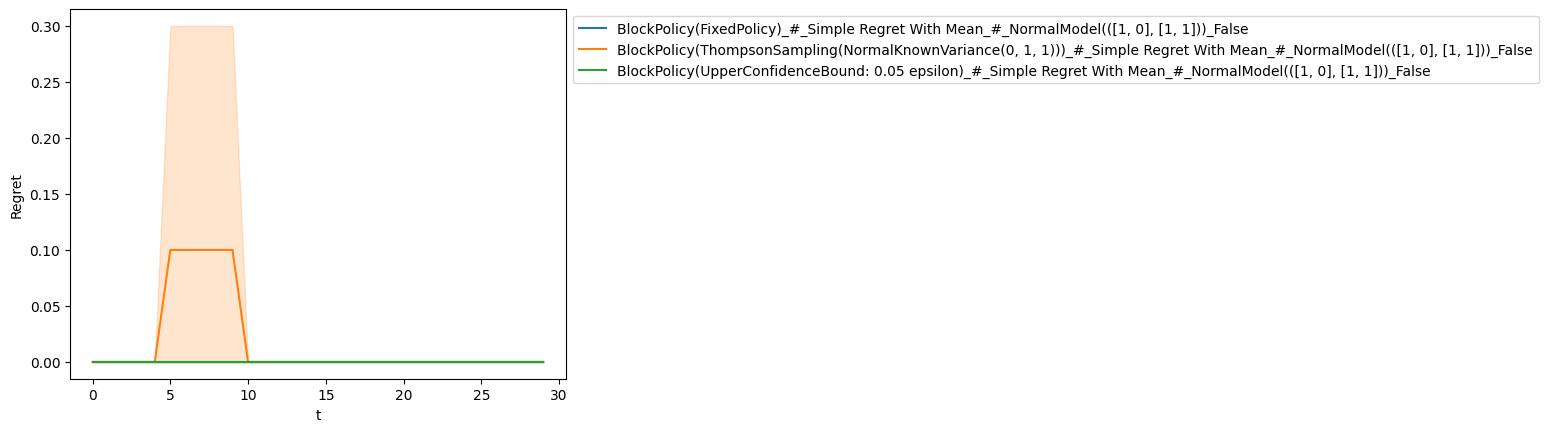

In [47]:
SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series if s["configuration"]["model"] == "NormalModel(([1, 0], [1, 1]))"],
    [
        SimpleRegretWithMean(),
        #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)
plt.savefig("mt_resources/5-optimization/02_simple_regret.pdf", bbox_inches="tight")

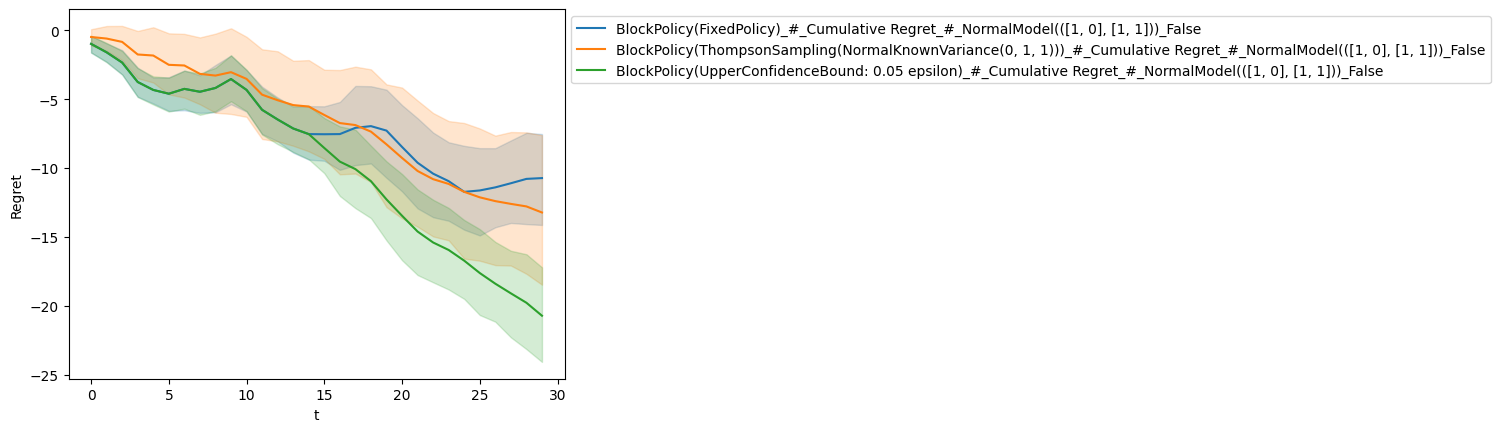

In [48]:
SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series if s["configuration"]["model"] == "NormalModel(([1, 0], [1, 1]))"],
    [
        CumulativeRegret(),
        #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)
plt.savefig("mt_resources/5-optimization/02_cumulative_regret.pdf", bbox_inches="tight")

In [49]:
plot_allocations_for_calculated_series(calculated_series)

/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .HeatMap.I    :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.II   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.III  :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.IV   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.V    :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.VI   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.VII  :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.VIII :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.IX   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.X    :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.XI   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.XII  :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.XIII :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.XIV  :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.XV   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)

Main effects:
- Thompson Sampling Suboptimal with few decision Points
- UpperConfidence Bound way more predictable
- When the bayesian model has a thin prior, sometimes UCB does not even explore anymore --> Bad for later analysis
- Thompson Sampling reacts way more sensitive to changes in the paraemters
- adds another source of uncertainty --> can help with exploring treatment effects
  

## Pooling vs Non-Pooling

In [19]:
# Data Generation Model
class PooledNormalModel(Model):
    def __init__(self, patient_id, prior_mean, prior_variance, variance):
        self.rng = numpy.random.default_rng(patient_id)
        self.prior_mean = prior_mean
        self.prior_variance = prior_variance
        self.variance = variance
        self.patient_id = patient_id

        # Draw patient effects randomly:
        self.mean = self.rng.normal(prior_mean, prior_variance)

    def generate_context(self, history):
        return {}

    @property
    def additional_config(self):
        return {"expectations_of_interventions": self.mean}

    def observe_outcome(self, action, context):
        treatment_index = action["treatment"]
        return {"outcome": self.rng.normal(self.mean[treatment_index], self.variance[treatment_index])}

    def __str__(self):
        return f"PooledNormalModel({self.prior_mean, self.prior_variance, self.variance})"

In [20]:
# Inference Model

class PooledNormalWithKnownVariance(BayesianModel):
    def __str__(self):
        return f"PooledNormalWithKnownVariance"
    
    def update_posterior(self, history, number_of_treatments):
        # Simple model with baseline + treatment effects + noise
        df = history.to_df()

        if len(df) == 0:
            return

        self.model = pymc.Model()
        with self.model:
            treatment_index = pymc.MutableData("treatment_index", pymc.intX(df[self.treatment_name]), dims="observation")
            patient_index = pymc.MutableData("patient_index", pymc.intX(df["patient_id"]), dims="observation")
            mu_treatment = pymc.Normal("mu_treatment", mu=0, sigma=1, dims="treatment", shape=2)
            mu_treatment_patient = pymc.Normal("mu_patient_treatment", mu=mu_treatment, sigma=1, dims=("patient", "treatment"), shape=(10, 2))
            outcome = pymc.Normal(
                "outcome", mu=mu_treatment_patient[patient_index, treatment_index], observed=df["outcome"], sigma=1, dims="observation", shape=len(df["outcome"]),
            )
            self.trace = pymc.sample(2000, progressbar=False)
    
    def data_to_coefficient_matrix(self, df):
        data = df[self.coefficient_names].to_numpy()
        data.shape = (len(df), len(self.coefficient_names))
        return data

    def approximate_max_probabilities(self, number_of_treatments, context):
        if context["t"] == 0:
            return [0.5, 0.5]
        assert (
            self.trace is not None
        ), "You called `approximate_max_probabilites` without updating the posterior"

        # Todo: we need to use the patient_id here
        patient_id = context["patient_id"]
        with self.model:
            pymc.set_data(
                {
                    "treatment_index": pymc.intX([0, 1]),
                    "patient_index": pymc.intX([patient_id] * 2),
                }
            )
            trace = pymc.sample_posterior_predictive(self.trace, var_names=["mu_patient_treatment"])
            max_indices = np.ravel(
                trace.posterior_predictive["mu_patient_treatment"].argmax(
                    dim="treatment"
                )
            )
        bin_counts = np.bincount(max_indices, minlength=number_of_treatments)
        return bin_counts / np.sum(bin_counts)

    def data_to_treatment_matrix(self, df, number_of_treatments):
        # Creating a Categorical Series makes get_dummies also create dummies for treatments which are not present in the dataset yet
        treatment_dummies = pandas.get_dummies(
            pandas.Categorical(
                df[self.treatment_name], categories=range(number_of_treatments)
            )
        )
        sorted_treatment_dummies = treatment_dummies.reindex(
            sorted(treatment_dummies.columns), axis=1
        )
        return pymc.floatX(sorted_treatment_dummies.to_numpy())


generating_pooling_scenario_I = lambda patient_id: PooledNormalModel(patient_id, prior_mean=[0, 0], prior_variance=[1,1], variance=[1,1])
generating_pooling_scenario_II = lambda patient_id: PooledNormalModel(patient_id, prior_mean=[1, 0], prior_variance=[1,1], variance=[1,1])

In [21]:
# Policies
pooled_fixed_policy = BlockPolicy(
    block_length = block_length,
    internal_policy = FixedPolicy(
        number_of_actions=2,
        inference_model = PooledNormalWithKnownVariance(),
    )
)  

pooled_thompson_sampling_policy = BlockPolicy(
    block_length = block_length,
    internal_policy = ThompsonSampling(
        inference_model=PooledNormalWithKnownVariance(),
        number_of_actions=2,
    )
)

pooled_ucb_policy = BlockPolicy(
    block_length = block_length,
    internal_policy = UpperConfidenceBound(
        inference_model=PooledNormalWithKnownVariance(),
        number_of_actions=2,
        epsilon=0.05,
    )
)

In [22]:
# Full crossover study
study_designs = {
    "n_patients": [2],
    "policy": [thompson_sampling_policy, fixed_policy, pooled_thompson_sampling_policy],
    "model_from_patient_id": [
        generating_pooling_scenario_I#, generating_scenario_II, generating_scenario_III, generating_scenario_IV, generating_scenario_V,
    ],
}
configurations = generate_configuration_cross_product(study_designs)

In [23]:
calculated_series, config_to_simulation_data = simulate_configurations(
    configurations, length
)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [mu_patient_treatment]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_treatment, mu_patient_treatment]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [mu_patient_treatment]


In [29]:
plot_allocations_for_calculated_series(calculated_series)

/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .HeatMap.I   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.II  :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.III :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)

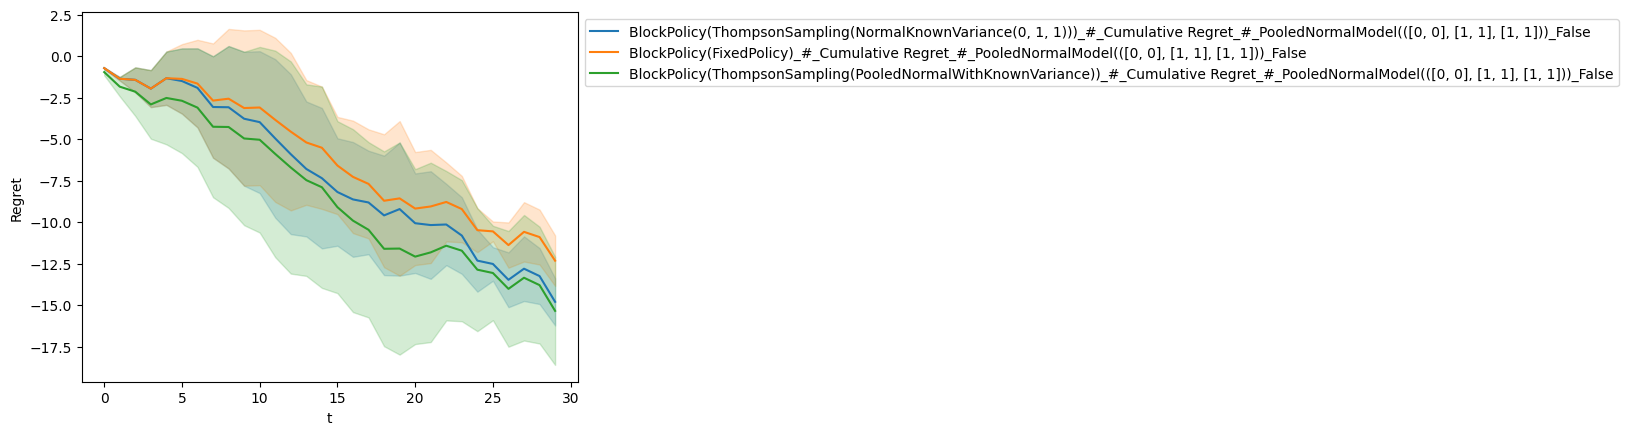

In [28]:
SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series],
    [
        CumulativeRegret(),
        #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)
plt.savefig("mt_resources/5-optimization/03_pooled_cumulative_regret.pdf", bbox_inches="tight")